In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Solving with Strassen and Conjugate Gradient optimized method

In [4]:
def NaiveMultiply(A,B):
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(0,C.shape[0]):
        for j in range(0,C.shape[1]):
            aux = 0
            for k in range(0,A.shape[1]):
                aux += A[i][k]*B[k][j]
            C[i][j] = aux
    return C

def nextPowerofTwo(n):
    return int(2**(ceil(log2(n))))

def ModifyMatrix(A):
    newA = A
    if(A.shape[1]%2 == 1):
        aux = np.zeros((A.shape[0],A.shape[1]+1))
        aux = np.insert(A,A.shape[1],0,axis=1)
        newA = aux
    if(newA.shape[0]%2 == 1):
        aux = np.zeros((newA.shape[0]+1,newA.shape[1]))
        aux = np.insert(newA,newA.shape[0],0,axis=0)
        newA = aux
    return newA

def FastMultiply(oldA,oldB):
    rows = oldA.shape[0]
    columns = oldB.shape[1]
    if(rows <= 2 or columns <=2 or oldA.shape[1] <= 2 or oldB.shape[0] <= 2):
        return np.matmul(oldA,oldB)
    
    A = ModifyMatrix(oldA)
    B = ModifyMatrix(oldB)
    N1 = A.shape[0]
    N2 = A.shape[1]
    N3 = B.shape[0]
    N4 = B.shape[1]
    

    a = A[0:N1//2,0:N2//2]
    b = A[0:N1//2,N2//2:N2//2+N2//2]
    c = A[N1//2:N1//2+N1//2,0:N2//2]
    d = A[N1//2:N1//2+N1//2,N2//2:N2//2+N2//2]
    
    e = B[0:N3//2,0:N4//2]
    f = B[0:N3//2,N4//2:N4//2+N4//2]
    g = B[N3//2:N3//2+N3//2,0:N4//2]
    h = B[N3//2:N3//2+N3//2,N4//2:N4//2+N4//2]
    
    
    p1 = FastMultiply(a,(f-h))
    p3 = FastMultiply((c+d),e)
    p2 = FastMultiply((a+b),h)
    p4 = FastMultiply(d,(g-e))
    p5 = FastMultiply((a+d),(e+h))
    p6 = FastMultiply((b-d),(g+h))
    p7 = FastMultiply((a-c),(e+f))
    
    
    C = np.zeros((rows,columns))
    
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4
    c22 = p1 + p5 - p3 - p7
    

    
    for i in range(0,N1//2):
        for j in range(0,N4//2):
            C[i][j] = c11[i][j]
            if(j + N4//2 < columns):
                C[i][j+N4//2] = c12[i][j]
            if(i + N1//2 < rows):
                C[i+N1//2][j] = c21[i][j]
                if(j + N4//2 < columns):
                    C[i+N1//2][j+N4//2] = c22[i][j]
    return C


# Conjugate Gradient

In [5]:
def conjugate_grad(A, b, x=None):
    n = b.shape[0]
    if not x:
        x = np.ones((n,1))
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = FastMultiply(np.transpose(r), r)
    for i in range(2*n):
        Ap = np.dot(A, p)
        
        alpha = r_k_norm /FastMultiply(np.transpose(p), Ap)
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = FastMultiply(np.transpose(r), r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        p = beta * p - r
    return x

# Solver 

In [6]:
NodesCondition = []
ForcesCondition = []

def UBoundaryCondition(nU,u,i):
    nU[i][0] = u
    NodesCondition.append(i)

def FBoundaryCondition(nF,f,i):
    nF[i][0] = f
    ForcesCondition.append(i)
    
def AssemblyStiffness(nStiffnessMatrix,k,i,j):
    nStiffnessMatrix[i][i] += k
    nStiffnessMatrix[i][j] += -k
    nStiffnessMatrix[j][i] += -k
    nStiffnessMatrix[j][j] += k

def Initialize(nStiffnessMatrix,nU,nF):
    for i in range(0,Nodes):
        nU[i][0] = math.pi
        nF[i][0] = math.pi
    for i in range(0,NumberOfElement):
        AssemblyStiffness(nStiffnessMatrix,K[i][0],int(K[i][1]),int(K[i][2]))

def PreSolvingStiffness(nStiffnessMatrix):
    nsize = Nodes-len(NodesCondition)
    newStiffness = np.zeros((nsize,nsize))
    contr = -1
    for i in range(0,Nodes):
        contc = -1
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        for j in range(0,Nodes):
            flagc = False
            for k in range(0,len(NodesCondition)):
                if(j == NodesCondition[k]):
                    flagc = True
                    break
            if(flagc):
                continue
            contc += 1
            newStiffness[contr][contc] = nStiffnessMatrix[i][j]
    return newStiffness


def PreSolvingF(nF,nS,nU):
    nsize = Nodes-len(NodesCondition)
    newF = np.zeros(nsize).reshape(nsize,1)
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            for k in range(0,Nodes):
                nF[k][0] = nF[k][0]-nS[k][i]*nU[i][0]
            continue

            
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        newF[contr][0] = nF[i][0]
    
    return newF
                      

def Solve(nStiffnessMatrix,nU,nF):
    newStiffness = PreSolvingStiffness(nStiffnessMatrix)
    newF = PreSolvingF(nF,nStiffnessMatrix,nU)
    u = conjugate_grad(newStiffness,newF)    
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        nU[i][0] = u[contr][0]
    nnF = FastMultiply(StiffnessMatrix,nU)
    return nU,nnF

# Defining the problem

In [7]:
NodesCondition = []
Nodes = 20
Nodes = 2*Nodes+1
E = 2*1e5 #MPA
L = 1500 #mm
b0 = 1000 #mm
bf = 0 #mm
e = 120 #mm
P = 50000 #N
K = []
y = 0.0784532e-3 #N/mm3
A = []

for i in range(0,Nodes):
    b = b0-i*((b0-bf)/(Nodes-1))
    nb = b0-(i+1)*(b0-bf)/(Nodes-1)
    A.append((b+nb)*e/2)
for i in range(0,Nodes-1):
    K.append([E*A[i]/(L/(Nodes-1)),i,i+1])

NumberOfElement = len(K)

StiffnessMatrix = np.zeros((Nodes,Nodes))
U = np.zeros(Nodes).reshape(Nodes,1)
F = np.zeros(Nodes).reshape(Nodes,1)

Initialize(StiffnessMatrix,U,F)
UBoundaryCondition(U,0,0)


for i in range(1,Nodes):
    if(i%2 == 1):
        W = y*(A[i]+A[i-1])*(L/(Nodes-1))
        FBoundaryCondition(F,W,i)
    else:
        FBoundaryCondition(F,0,i)
        
if((NumberOfElement//2)%2 == 1):
    W = y*(A[NumberOfElement//2]+A[NumberOfElement//2-1])*(L/(Nodes-1))
    FBoundaryCondition(F,P+W,NumberOfElement//2)
else:
    FBoundaryCondition(F,P,NumberOfElement//2)

U,F=Solve(StiffnessMatrix,U,F)


#print("Stiffness Matrix:\n",StiffnessMatrix,'\n')
#print("Displacements:\n",U,'\n')
#print("Forces:\n",F[0])

# Visualizing the data

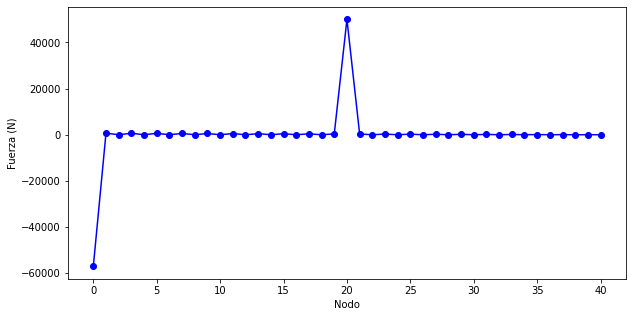

In [8]:
plt.figure(figsize=(10,5))
plt.xlabel("Nodo")
plt.ylabel("Fuerza (N)")
plt.plot(F,'-bo')
#plt.show()
#plt.savefig("forze20.pdf")

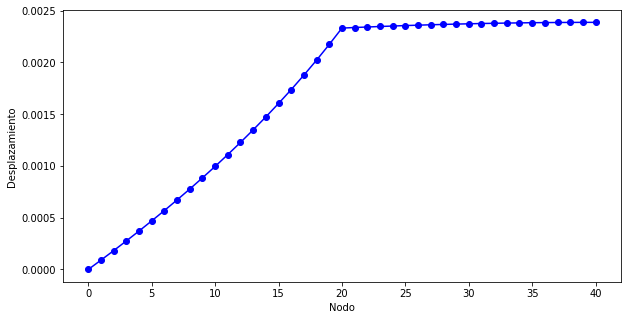

In [9]:
plt.figure(figsize=(10,5))
plt.xlabel("Nodo")
plt.ylabel("Desplazamiento")
plt.plot(U,'-ob')
#plt.show()
#plt.savefig("def30.pdf")

In [10]:
Displacements_data =  pd.DataFrame(data=U, columns=["Desplazamientos"])
Forces_data = pd.DataFrame(data=F, columns=["Fuerzas"])
Displacements_data.join(Forces_data)

,Desplazamientos,Fuerzas
0,0.000000,-5.706079e+04
1,0.000090,6.884268e+02
2,0.000182,7.997733e-08
3,0.000276,6.531229e+02
4,0.000371,-1.606531e-08
5,0.000469,6.178190e+02
6,0.000569,-3.840541e-07
7,0.000672,5.825150e+02
8,0.000777,-4.492467e-07
9,0.000885,5.472111e+02


In [16]:
nU = []
nE = []
nstrain = []
sigma = []
strain = []
defor = []

dL = L/(Nodes-1)

for i in range(0,len(U)-1):
    strain.append(-U[i][0]/(dL)+U[i+1][0]/(dL))
    defor.append(strain[i]*dL)
    sigma.append(strain[i]*E)

print("Esfuerzos (MPa):\n",np.array(sigma).reshape((Nodes-1,1)))

Esfuerzos (MPa):
 [[4.81525637e-01]
 [4.88072391e-01]
 [5.01087655e-01]
 [5.08851491e-01]
 [5.23185336e-01]
 [5.32380863e-01]
 [5.48272829e-01]
 [5.59168249e-01]
 [5.76919622e-01]
 [5.89854571e-01]
 [6.09849641e-01]
 [6.25260656e-01]
 [6.47997408e-01]
 [6.66455131e-01]
 [6.92590627e-01]
 [7.14855560e-01]
 [7.45274946e-01]
 [7.72383531e-01]
 [8.08308347e-01]
 [8.41710520e-01]
 [3.01743077e-02]
 [2.57623346e-02]
 [2.72344680e-02]
 [2.28227491e-02]
 [2.42951845e-02]
 [1.98838283e-02]
 [2.13567044e-02]
 [1.69458912e-02]
 [1.84194470e-02]
 [1.40095000e-02]
 [1.54841842e-02]
 [1.10757459e-02]
 [1.25525120e-02]
 [8.14706308e-03]
 [9.62834727e-03]
 [5.23021333e-03]
 [6.72456000e-03]
 [2.35359600e-03]
 [3.92266000e-03]
 [1.26038503e-12]]


In [17]:
heatmap = np.zeros((Nodes-1,Nodes-1))
for i in range(0,Nodes-1):
    for j in range(0,Nodes-1):
        if(2*j>=i-1 and 2*(Nodes-1)-2*j-1 >= i):
            heatmap[i][j] = 1e3*sigma[i]
        else:
            heatmap[i][j] = -6e1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:

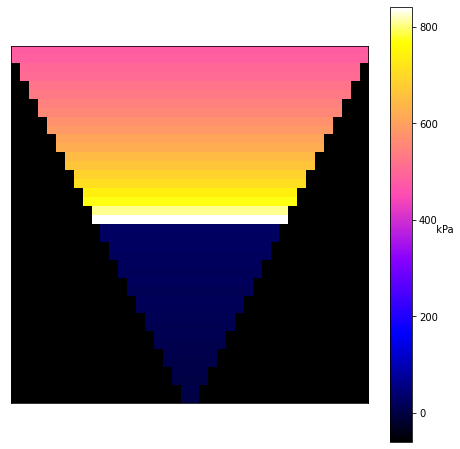

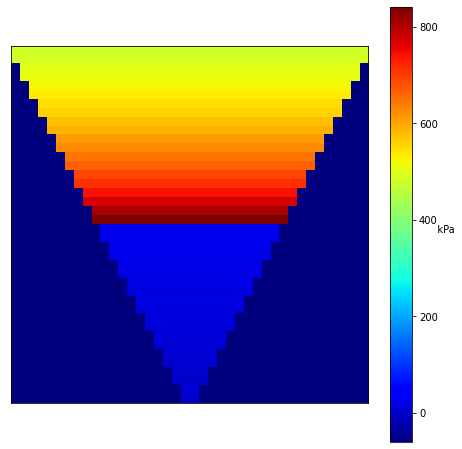

In [18]:
plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(heatmap,cmap='gnuplot2',interpolation='nearest')
plt.colorbar().set_label('  kPa',rotation=0)
#plt.savefig("21.pdf")
#plt.show()

plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(heatmap,cmap='jet',interpolation='nearest')
plt.colorbar().set_label('   kPa',rotation=0)
#plt.savefig("21.pdf")
#plt.show()


In [19]:
hdefor = np.zeros((U.shape[0]-1,U.shape[0]-1))
for i in range(0,U.shape[0]-1):
    for j in range(0,U.shape[0]-1):
        if(2*j>=i-1 and 2*U.shape[0]-2*j-1-2 >= i):
            hdefor[i][j] = U[i][0]
        else:
            hdefor[i][j] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:

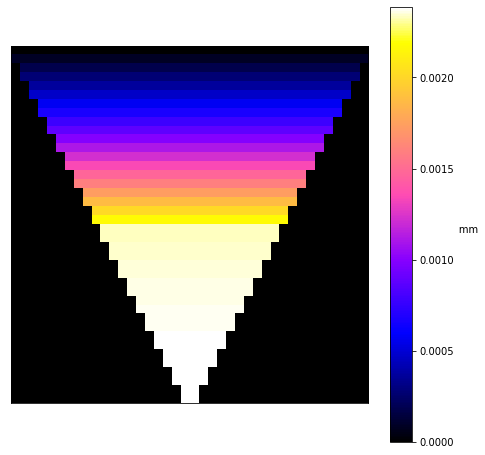

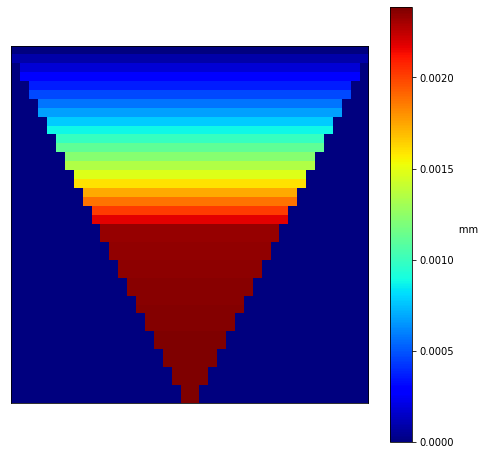

In [20]:
plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(hdefor,cmap='gnuplot2',interpolation='nearest')
plt.colorbar().set_label('       mm',rotation=0)
#plt.savefig("22.pdf")
#plt.show()

plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(hdefor,cmap='jet',interpolation='nearest')
plt.colorbar().set_label('       mm',rotation=0)
#plt.savefig("gg.pdf")
#plt.show()
